In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import numpy as np
from torchvision.transforms import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
from torchvision import models
from sklearn.preprocessing import LabelEncoder
import pandas as pd
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
from pathlib import Path

base_dir = Path("C:/Users/nihal/Downloads/archive (1)")
train_df = pd.read_csv(base_dir / "train.csv")
val_df   = pd.read_csv(base_dir / "val.csv")

train_df["image:FILE"] = train_df["image:FILE"].apply(lambda x: str(base_dir / x))
val_df["image:FILE"]   = val_df["image:FILE"].apply(lambda x: str(base_dir / x))


In [3]:
print("Training set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("\nCategory distribution in training set:")
print(train_df["category"].value_counts())

Training set shape: (1034, 2)
Validation set shape: (133, 2)

Category distribution in training set:
category
2    348
1    345
0    341
Name: count, dtype: int64


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [5]:
# Fit label encoder on all categories (train + val, so all classes are included)
label_encoder = LabelEncoder()
label_encoder.fit(pd.concat([train_df["category"], val_df["category"]]))

# Store the class names for later (e.g. inference)
class_names = label_encoder.classes_.tolist()
print("Classes:", class_names)


Classes: [0, 1, 2]


In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.labels = label_encoder.transform(dataframe["category"].values)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, "image:FILE"]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image) 

        return image, torch.tensor(label, dtype=torch.long)

In [7]:
train_dataset = CustomImageDataset(train_df, transform=transform)
val_dataset   = CustomImageDataset(val_df, transform=transform)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

Train samples: 1034
Val samples: 133


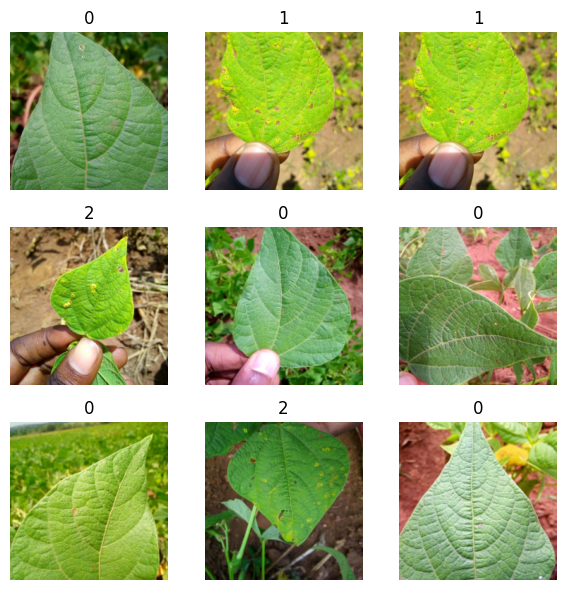

In [8]:
def denormalize(img_tensor, mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]):
    """Undo normalization for visualization."""
    img = img_tensor.clone().permute(1,2,0).numpy()  
    img = img * std + mean                          
    return np.clip(img, 0, 1)                       

# Show 3x3 grid of random training images
n_rows, n_cols = 3, 3
fig, axarr = plt.subplots(n_rows, n_cols, figsize=(6,6))
for row in range(n_rows):
    for col in range(n_cols):
        image, label = train_dataset[np.random.randint(0, len(train_dataset))]
        img = denormalize(image.cpu())
        axarr[row,col].imshow(img)
        axarr[row,col].set_title(class_names[label])
        axarr[row,col].axis('off')

plt.tight_layout()
plt.show()


In [9]:
lr=0.001
batch_size=16
EPOCHS=15

In [10]:
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)

In [11]:
googlenet=models.googlenet(weights='DEFAULT')

In [12]:
for param in googlenet.parameters():
    param.requires_grad=True

In [13]:
googlenet.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [14]:
googlenet.fc=nn.Linear(googlenet.fc.in_features,len(train_df["category"].unique()))
googlenet.fc

Linear(in_features=1024, out_features=3, bias=True)

In [15]:
googlenet.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [16]:
loss_fn=nn.CrossEntropyLoss()
optimizer=Adam(googlenet.parameters(),lr=lr)

In [17]:
total_train_loss_plot = []
total_val_loss_plot   = []
total_train_acc_plot  = []
total_val_acc_plot    = []

for epoch in range(EPOCHS):
    # --- Training ---
    googlenet.train()
    train_loss = 0
    train_correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = googlenet(images)
        loss = loss_fn(outputs, labels)

        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_acc = train_correct / len(train_dataset) * 100

    # --- Validation ---
    googlenet.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = googlenet(images)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / len(val_dataset) * 100

    # --- Save metrics ---
    total_train_loss_plot.append(avg_train_loss)
    total_val_loss_plot.append(avg_val_loss)
    total_train_acc_plot.append(train_acc)
    total_val_acc_plot.append(val_acc)

    # --- Print progress ---
    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch 1/15 | Train Loss: 0.4721, Train Acc: 81.04% | Val Loss: 0.2698, Val Acc: 91.73%
Epoch 2/15 | Train Loss: 0.1893, Train Acc: 93.52% | Val Loss: 0.3295, Val Acc: 87.97%
Epoch 3/15 | Train Loss: 0.1623, Train Acc: 95.36% | Val Loss: 0.2330, Val Acc: 92.48%
Epoch 4/15 | Train Loss: 0.1326, Train Acc: 94.87% | Val Loss: 0.1473, Val Acc: 93.98%
Epoch 5/15 | Train Loss: 0.1138, Train Acc: 96.03% | Val Loss: 0.3004, Val Acc: 87.97%
Epoch 6/15 | Train Loss: 0.1258, Train Acc: 95.84% | Val Loss: 0.3937, Val Acc: 86.47%
Epoch 7/15 | Train Loss: 0.0915, Train Acc: 97.10% | Val Loss: 0.0498, Val Acc: 97.74%
Epoch 8/15 | Train Loss: 0.0665, Train Acc: 97.78% | Val Loss: 0.0199, Val Acc: 100.00%
Epoch 9/15 | Train Loss: 0.0641, Train Acc: 97.68% | Val Loss: 0.0543, Val Acc: 97.74%
Epoch 10/15 | Train Loss: 0.0616, Train Acc: 98.45% | Val Loss: 0.0644, Val Acc: 98.50%
Epoch 11/15 | Train Loss: 0.0157, Train Acc: 99.52% | Val Loss: 0.0376, Val Acc: 99.25%
Epoch 12/15 | Train Loss: 0.0592, Train 

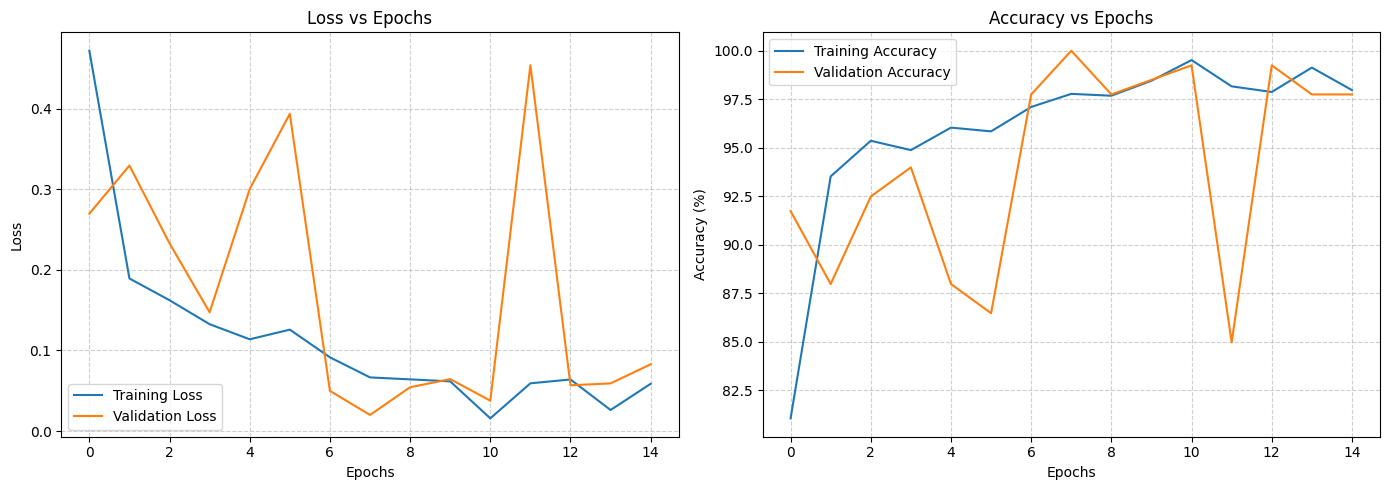

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# --- Loss Plot ---
ax[0].plot(total_train_loss_plot, label="Training Loss")
ax[0].plot(total_val_loss_plot, label="Validation Loss")
ax[0].set_title("Loss vs Epochs")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid(True, linestyle="--", alpha=0.6)

# --- Accuracy Plot ---
ax[1].plot(total_train_acc_plot, label="Training Accuracy")
ax[1].plot(total_val_acc_plot, label="Validation Accuracy")
ax[1].set_title("Accuracy vs Epochs")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].legend()
ax[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


In [19]:
# Option B: Transfer learning with frozen layers
googlenet_frozen = models.googlenet(weights='DEFAULT')
for param in googlenet_frozen.parameters():
    param.requires_grad = False

googlenet_frozen.fc = nn.Linear(googlenet_frozen.fc.in_features, len(train_df["category"].unique()))
googlenet_frozen.fc.requires_grad = True

googlenet_frozen.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [20]:
optimizer_frozen = Adam(googlenet_frozen.fc.parameters(), lr=lr)

In [21]:
# Training and validation loops for frozen GoogLeNet
total_train_loss_plot = []
total_val_loss_plot   = []
total_train_acc_plot  = []
total_val_acc_plot    = []

for epoch in range(EPOCHS):
    # --- Training ---
    googlenet.train()
    train_loss = 0
    train_correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = googlenet_frozen(images)
        loss = loss_fn(outputs, labels)

        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_acc = train_correct / len(train_dataset) * 100

    # --- Validation ---
    googlenet.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = googlenet_frozen(images)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / len(val_dataset) * 100

    # --- Save metrics ---
    total_train_loss_plot.append(avg_train_loss)
    total_val_loss_plot.append(avg_val_loss)
    total_train_acc_plot.append(train_acc)
    total_val_acc_plot.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch 1/15 | Train Loss: 1.0627, Train Acc: 46.23% | Val Loss: 1.1455, Val Acc: 33.83%
Epoch 2/15 | Train Loss: 1.0678, Train Acc: 45.94% | Val Loss: 1.1546, Val Acc: 32.33%
Epoch 3/15 | Train Loss: 1.0696, Train Acc: 44.87% | Val Loss: 1.1448, Val Acc: 35.34%
Epoch 4/15 | Train Loss: 1.0689, Train Acc: 46.42% | Val Loss: 1.1264, Val Acc: 36.84%
Epoch 5/15 | Train Loss: 1.0667, Train Acc: 45.45% | Val Loss: 1.1342, Val Acc: 31.58%
Epoch 6/15 | Train Loss: 1.0653, Train Acc: 45.36% | Val Loss: 1.1305, Val Acc: 35.34%
Epoch 7/15 | Train Loss: 1.0656, Train Acc: 46.23% | Val Loss: 1.1307, Val Acc: 39.10%
Epoch 8/15 | Train Loss: 1.0674, Train Acc: 47.20% | Val Loss: 1.1450, Val Acc: 36.84%
Epoch 9/15 | Train Loss: 1.0679, Train Acc: 45.84% | Val Loss: 1.1439, Val Acc: 31.58%
Epoch 10/15 | Train Loss: 1.0650, Train Acc: 45.26% | Val Loss: 1.1432, Val Acc: 34.59%
Epoch 11/15 | Train Loss: 1.0668, Train Acc: 45.84% | Val Loss: 1.1375, Val Acc: 31.58%
Epoch 12/15 | Train Loss: 1.0712, Train A

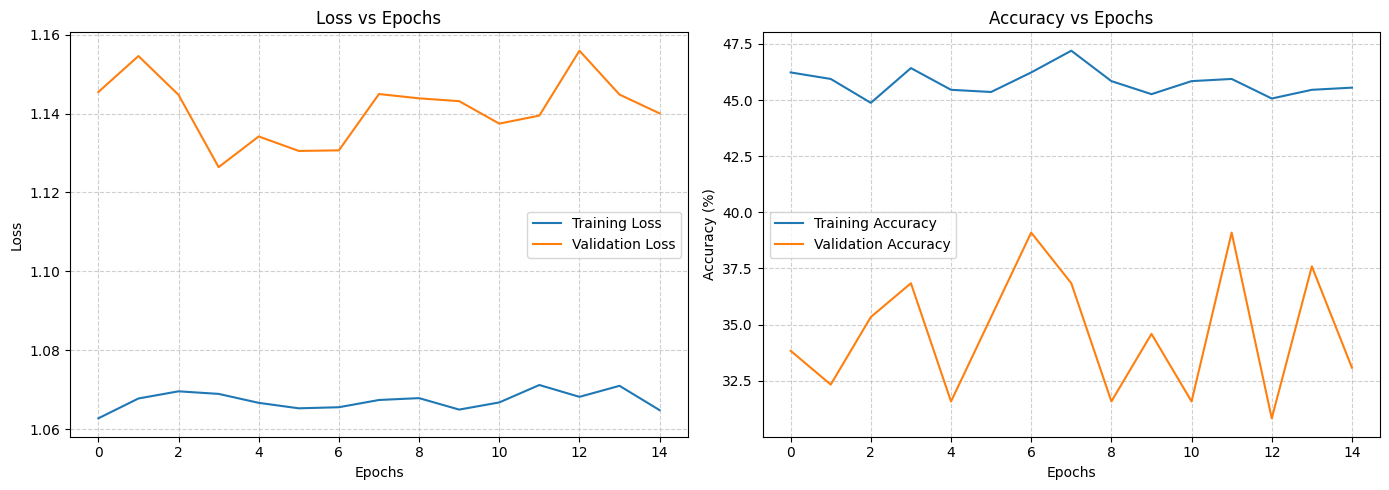

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# --- Loss Plot ---
ax[0].plot(total_train_loss_plot, label="Training Loss")
ax[0].plot(total_val_loss_plot, label="Validation Loss")
ax[0].set_title("Loss vs Epochs")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid(True, linestyle="--", alpha=0.6)

# --- Accuracy Plot ---
ax[1].plot(total_train_acc_plot, label="Training Accuracy")
ax[1].plot(total_val_acc_plot, label="Validation Accuracy")
ax[1].set_title("Accuracy vs Epochs")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].legend()
ax[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()
